# Classification results


In the following sections, each comparison is presented:

## Fergus-Recurrent vs Fergus-Neuralized

##### Fergus-R Convolutional vs Fergus-N Convolutional
> Question: is R better than N with convolutional embeddings?

##### Fergus-R Token vs Fergus-N Token 
> Question: is R better than N with token embeddings?

##### Fergus-R MInimal Token vs Fergus-N Minimal Token 
> Question: is R better than N with token embeddings?

<br>
--------

## Convolutional vs Token vs Minimal Token Embeddings
--------

##### Fergus-R Convolutional vs Fergus-R Token
>Question: are convolutions better in the R model?


##### Fergus-N Convolutional vs Fergus-N Token 
> Question: are convolutions better in the N model?

In [3]:
from sqlitedict import SqliteDict
import sys
import os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

ROOT = '/home/cogniton/research/code/paper_repos/coling_2016'
sys.path.append(ROOT)


import fergus

In [16]:
"""
Stats parsing and comparsion functions
"""
def parse_stats(stats, version):
    assert version == 'before_astar' or version == 'after_astar'
    out = []
    for datum_index, datum in sorted(stats.items()):
        new_datum = {'datum_index': datum_index, 
                     'time': datum['time'], 
                     'length': datum['length'], 
                     'version': version}
        for stat_type, binary_data in datum[version].items():
            new_datum[stat_type] = float(sum(binary_data))/len(binary_data)
        out.append(new_datum)
    return pd.DataFrame(out)

def load_data(db_name, tablename='tagged_data', root_path=''):
    import os
    db_name = os.path.join(root_path, db_name)
    with SqliteDict(db_name, tablename=tablename) as db:
        data = db.items()
    print(len(data))
    stats = {int(d):datum[-1] for d, datum in data}
    return pd.concat([parse_stats(stats, 'before_astar'), 
                      parse_stats(stats, 'after_astar')])

def ttest_rel(df1, df2, stat_name, data_version, ax=None):
    df1 = df1[df1.version==data_version]
    df2 = df2[df2.version==data_version]
    shared_indices = set(df1.datum_index).intersection(df2.datum_index)
    df1_subset = df1[df1.datum_index.isin(shared_indices)][stat_name]
    df2_subset = df2[df2.datum_index.isin(shared_indices)][stat_name]
    ttest = scipy.stats.ttest_rel(df1_subset, df2_subset)
    return ttest, df1_subset, df2_subset


def pretty_compare(model1, model2, model1_name, model2_name, 
                           embedding1_name, embedding2_name, data_version):
    print("{}-{} vs {}-{} embeddings {}".format(model1_name, 
                                             embedding1_name,
                                             model2_name,
                                             embedding2_name,
                                             data_version))
    print("="*30)
    stat_keys = [('correct', 'mean'), ('time', 'median')]
    func_map = {'mean': lambda x: np.mean(x), 'median': lambda x: np.median(x)}
    fig, axes = plt.subplots(len(stat_keys), 1, figsize=(10,15))
    
    for i, (stat_type, stat_functype) in enumerate(stat_keys):
        n_dash = (20-len(stat_type))//2
        print("{:^20}".format("-"*n_dash+stat_type+"-"*n_dash))
        (stat,  
         m1subset, m2subset) = ttest_rel(model1, model2, stat_type, data_version)
        format1 = "{}-{}".format(model1_name, embedding1_name)
        format2 = "{}-{}".format(model2_name, embedding2_name)
        model1_stat = func_map[stat_functype](m1subset)
        model2_stat = func_map[stat_functype](m2subset)
        print("\t{:<30} = {:0.4f}".format("{} {}".format(format1,stat_functype),
                                          model1_stat))
        print("\t{:<30} = {:0.4f}".format("{} {}".format(format2,stat_functype), 
                                          model2_stat))
        print("\t pvalue = {}".format(stat.pvalue))
        print("{:^20}\n".format("-"*15))
        axes[i].hist(m1subset, bins=30, color='blue', alpha=0.5, 
                     label=format1)
        axes[i].hist(m2subset, bins=30, color='red', alpha=0.5, 
                    label=format2)
        axes[i].set_xlabel(stat_type, size=14)
        axes[i].legend(loc=2)
            
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle(data_version, size=18)
        

In [5]:
data_root = os.path.join(fergus.ROOTPATH, '../data')

fr_conv = load_data('fergusr_convolutional_test.db', root_path=data_root)
fr_token = load_data('fergusr_token_test.db', root_path=data_root)
fr_mintoken = load_data('fergusr_minimaltoken_test.db', root_path=data_root)

fn_conv = load_data('fergusn_convolutional_test.db', root_path=data_root) 
fn_token = load_data('fergusn_token_test.db', root_path=data_root)
fn_mintoken = load_data('fergusn_minimaltoken_test.db', root_path=data_root)

2405
2407
2397
2410
2410
2410


Fergus-R-Convolutional vs Fergus-N-Convolutional embeddings before_astar
------correct------ 
	Fergus-R-Convolutional mean    = 0.6762
	Fergus-N-Convolutional mean    = 0.5817
	 pvalue = 4.23517704224e-290
  ---------------   

--------time--------
	Fergus-R-Convolutional median  = 0.3022
	Fergus-N-Convolutional median  = 1.9797
	 pvalue = 0.0
  ---------------   

Fergus-R-Convolutional vs Fergus-N-Convolutional embeddings after_astar
------correct------ 
	Fergus-R-Convolutional mean    = 0.5704
	Fergus-N-Convolutional mean    = 0.5740
	 pvalue = 0.144628666926
  ---------------   

--------time--------
	Fergus-R-Convolutional median  = 0.3022
	Fergus-N-Convolutional median  = 1.9797
	 pvalue = 0.0
  ---------------   



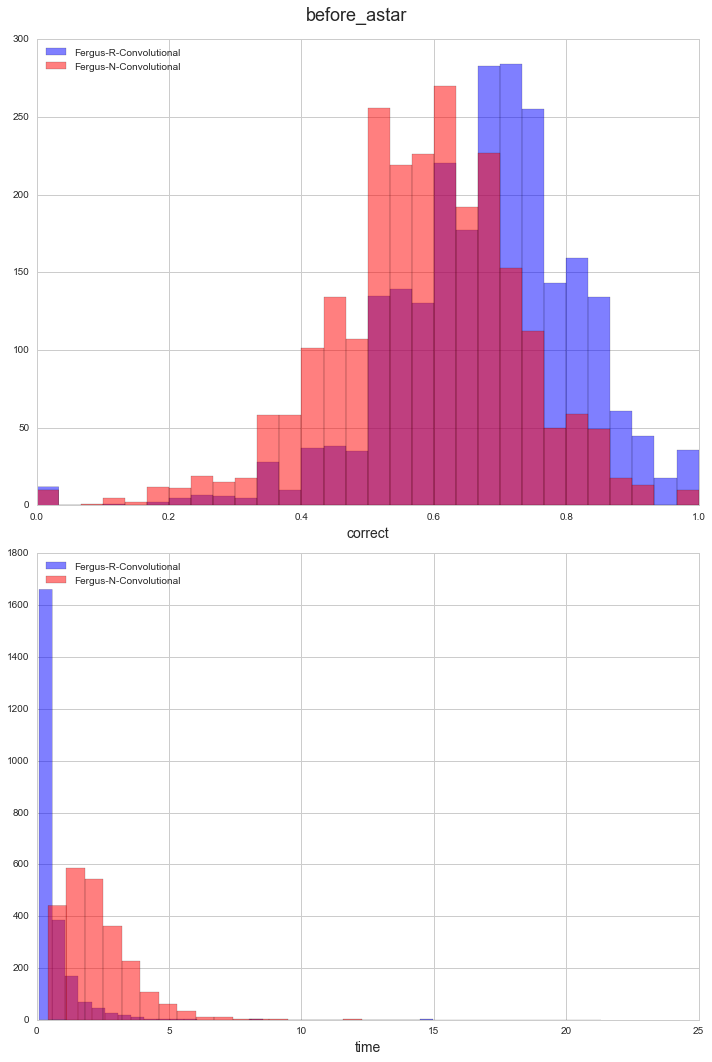

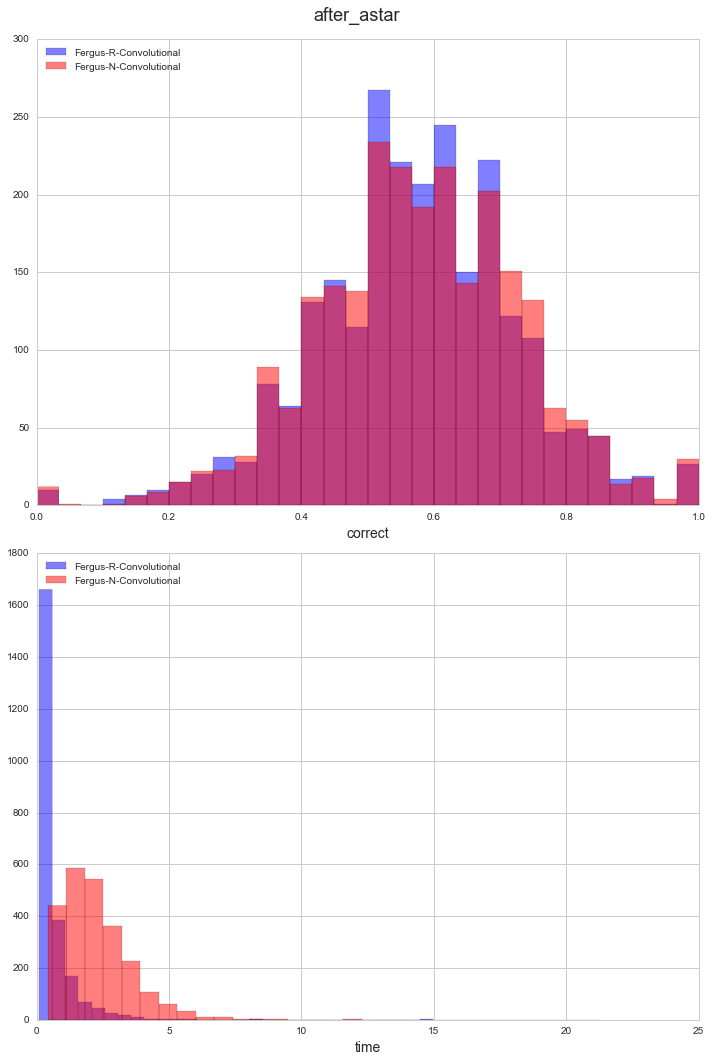

In [17]:
'''
this compares the recurrent vs the neuralized model 
with convolutional embeddings
'''
pretty_compare(fr_conv, fn_conv, "Fergus-R", "Fergus-N", 
                                    "Convolutional", "Convolutional", 
                                    "before_astar")
pretty_compare(fr_conv, fn_conv, "Fergus-R", "Fergus-N", 
                                    "Convolutional", "Convolutional", 
                                    "after_astar")

Fergus-R-Token vs Fergus-N-Token embeddings before_astar
------correct------ 
	Fergus-R-Token mean            = 0.8264
	Fergus-N-Token mean            = 0.6069
	 pvalue = 0.0
  ---------------   

--------time--------
	Fergus-R-Token median          = 0.3650
	Fergus-N-Token median          = 1.8059
	 pvalue = 0.0
  ---------------   

Fergus-R-Token vs Fergus-N-Token embeddings after_astar
------correct------ 
	Fergus-R-Token mean            = 0.6273
	Fergus-N-Token mean            = 0.5563
	 pvalue = 1.10215943305e-148
  ---------------   

--------time--------
	Fergus-R-Token median          = 0.3650
	Fergus-N-Token median          = 1.8059
	 pvalue = 0.0
  ---------------   



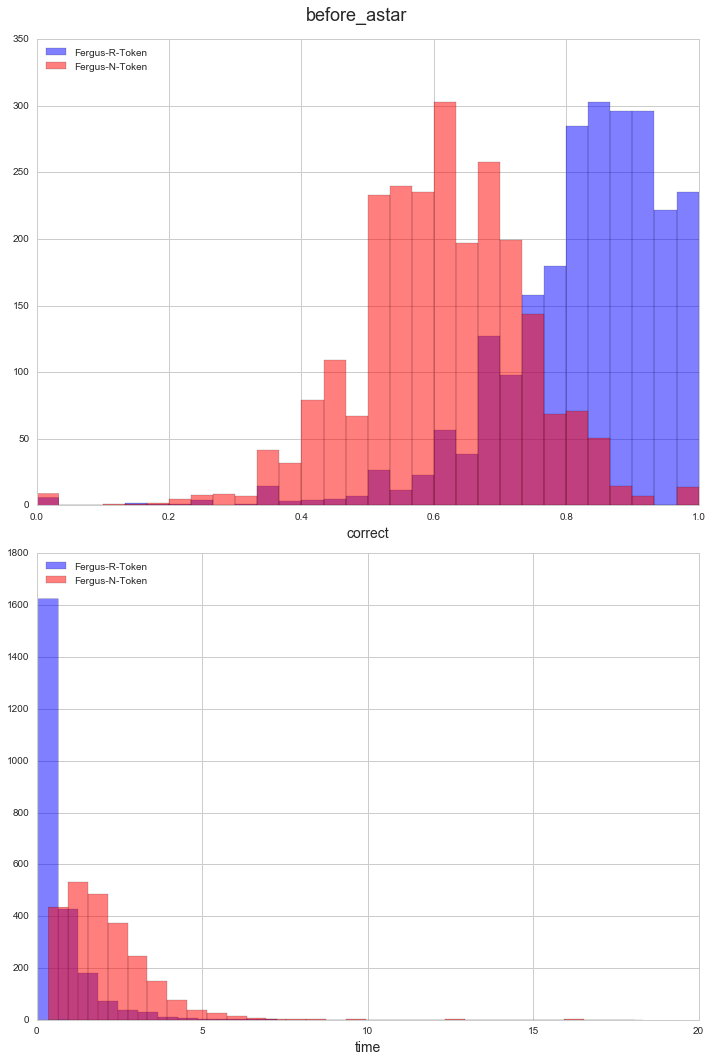

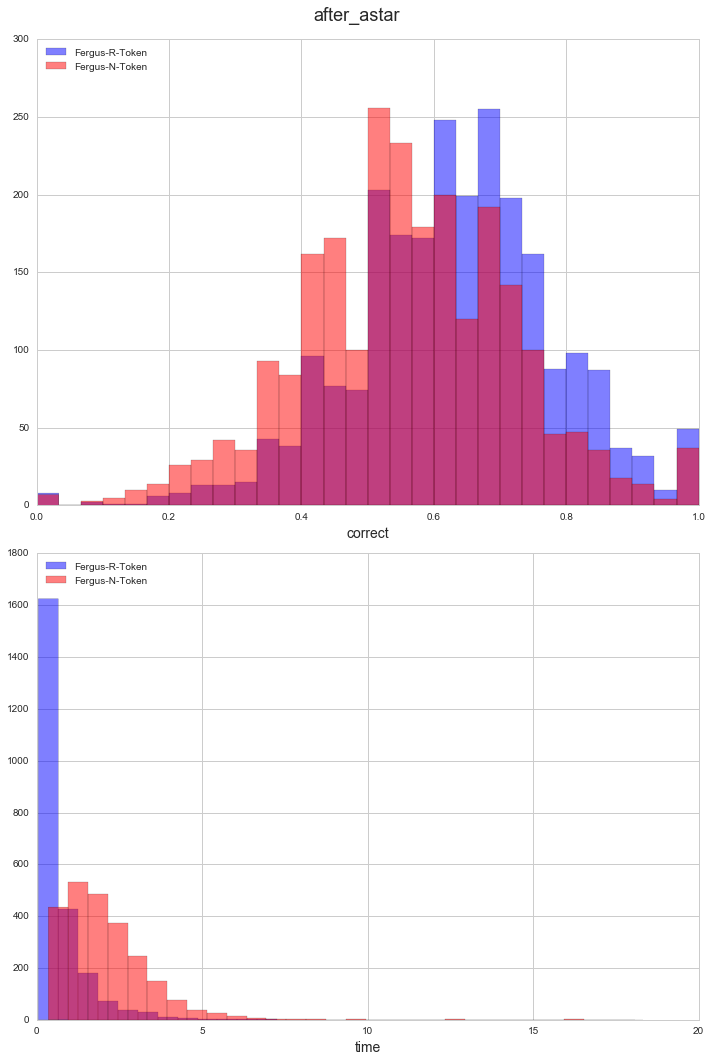

In [18]:
'''
this compares the recurrent model vs the neuralized model
with token embeddings
'''
pretty_compare(fr_token, fn_token, "Fergus-R", "Fergus-N", 
                                  "Token", "Token", "before_astar")
pretty_compare(fr_token, fn_token, "Fergus-R", "Fergus-N", 
                                  "Token", "Token", "after_astar")

Fergus-R-Minimal Token vs Fergus-N-Minimal Token embeddings before_astar
------correct------ 
	Fergus-R-Minimal Token mean    = 0.1014
	Fergus-N-Minimal Token mean    = 0.5214
	 pvalue = 0.0
  ---------------   

--------time--------
	Fergus-R-Minimal Token median  = 0.5414
	Fergus-N-Minimal Token median  = 2.0248
	 pvalue = 0.0
  ---------------   

Fergus-R-Minimal Token vs Fergus-N-Minimal Token embeddings after_astar
------correct------ 
	Fergus-R-Minimal Token mean    = 0.1967
	Fergus-N-Minimal Token mean    = 0.5421
	 pvalue = 0.0
  ---------------   

--------time--------
	Fergus-R-Minimal Token median  = 0.5414
	Fergus-N-Minimal Token median  = 2.0248
	 pvalue = 0.0
  ---------------   



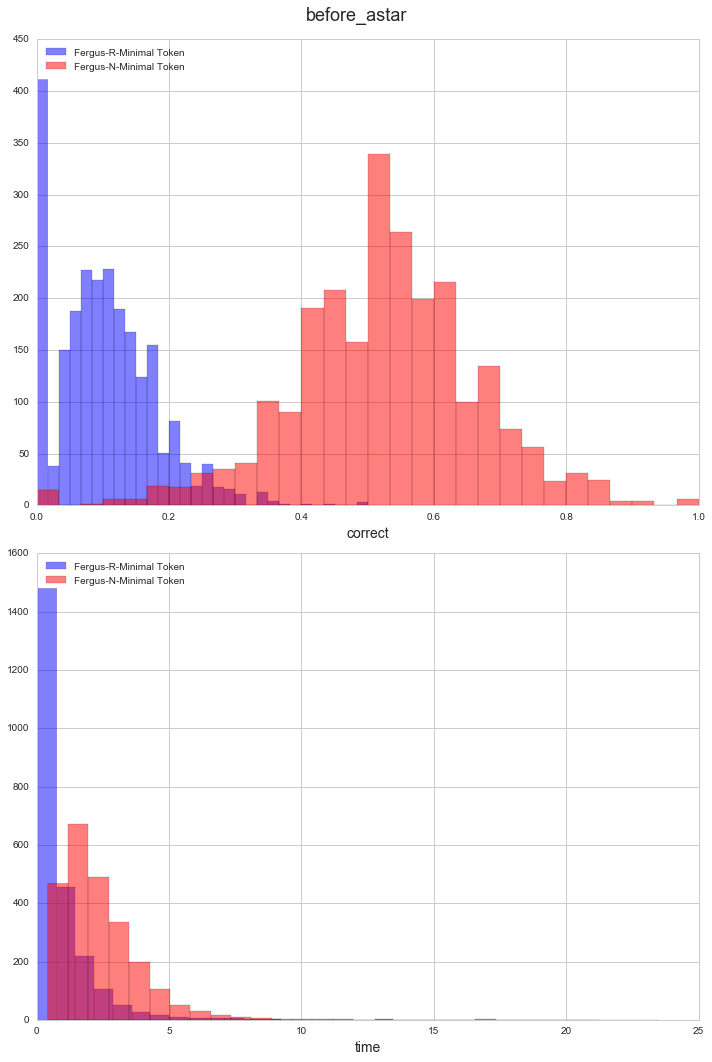

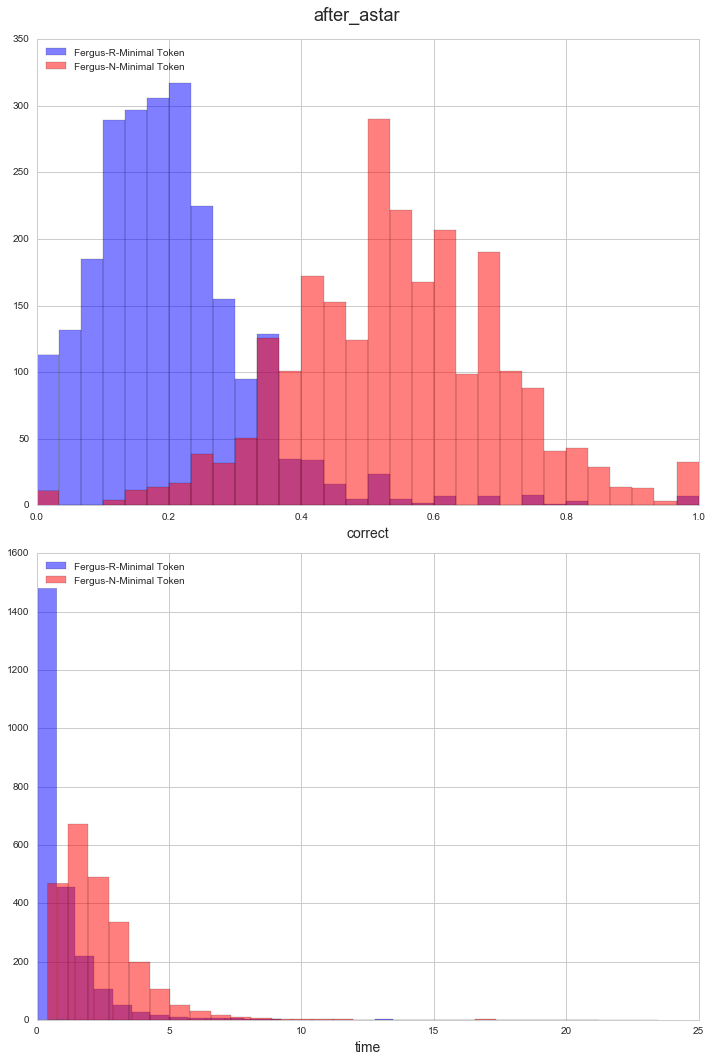

In [19]:
'''
this compares the recurrent model vs the neuralized model
with minimal token embeddings
'''
pretty_compare(fr_mintoken, fn_mintoken, "Fergus-R", "Fergus-N", 
                                  "Minimal Token", "Minimal Token", "before_astar")
pretty_compare(fr_mintoken, fn_mintoken, "Fergus-R", "Fergus-N", 
                                  "Minimal Token", "Minimal Token", "after_astar")

Fergus-R-Convolutional vs Fergus-R-Token embeddings before_astar
------correct------ 
	Fergus-R-Convolutional mean    = 0.6763
	Fergus-R-Token mean            = 0.8268
	 pvalue = 0.0
  ---------------   

--------time--------
	Fergus-R-Convolutional median  = 0.3022
	Fergus-R-Token median          = 0.3658
	 pvalue = 9.78549888131e-19
  ---------------   

Fergus-R-Convolutional vs Fergus-R-Token embeddings after_astar
------correct------ 
	Fergus-R-Convolutional mean    = 0.5704
	Fergus-R-Token mean            = 0.6272
	 pvalue = 6.1618295878e-113
  ---------------   

--------time--------
	Fergus-R-Convolutional median  = 0.3022
	Fergus-R-Token median          = 0.3658
	 pvalue = 9.78549888131e-19
  ---------------   

Fergus-R-Convolutional vs Fergus-R-Minimal Token embeddings before_astar
------correct------ 
	Fergus-R-Convolutional mean    = 0.6767
	Fergus-R-Minimal Token mean    = 0.1013
	 pvalue = 0.0
  ---------------   

--------time--------
	Fergus-R-Convolutional median  = 0

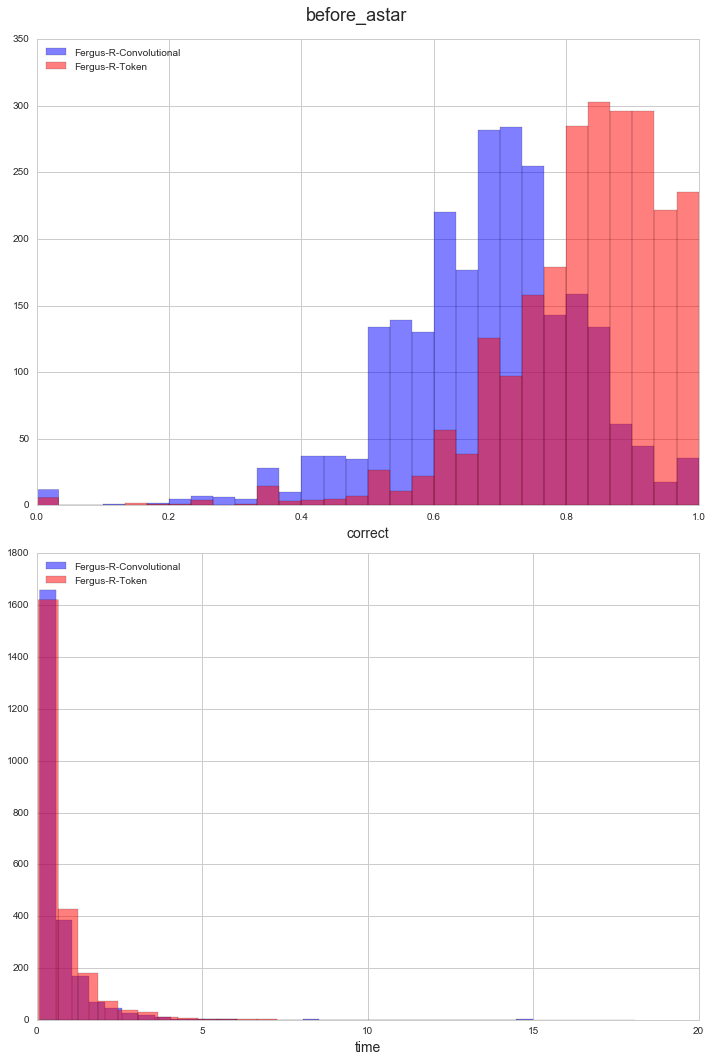

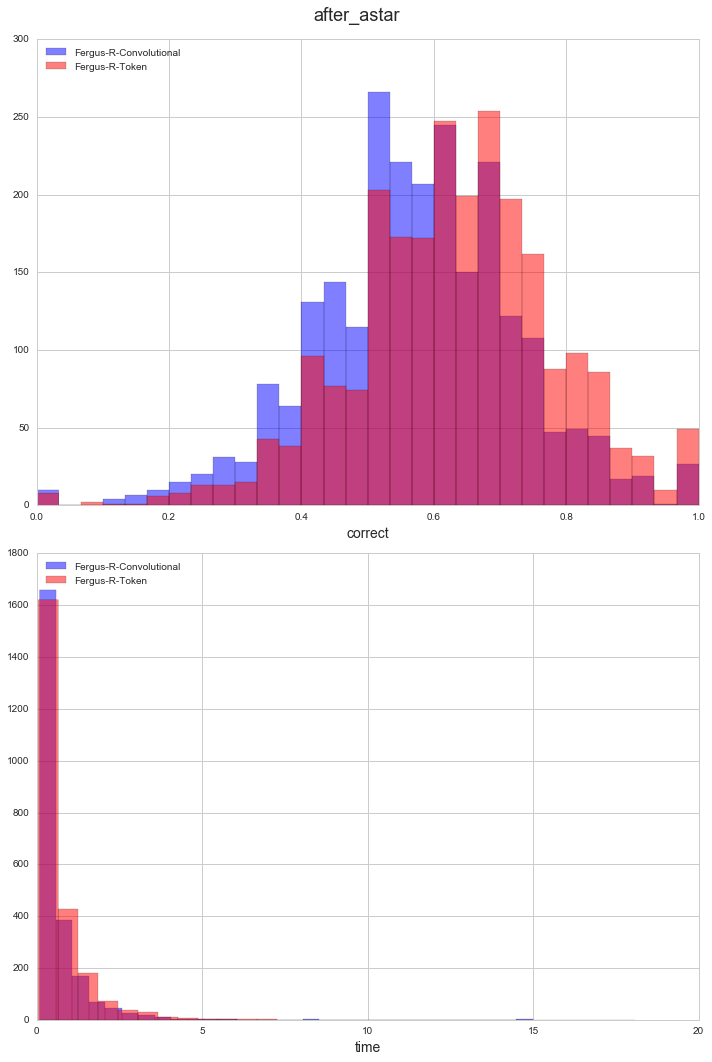

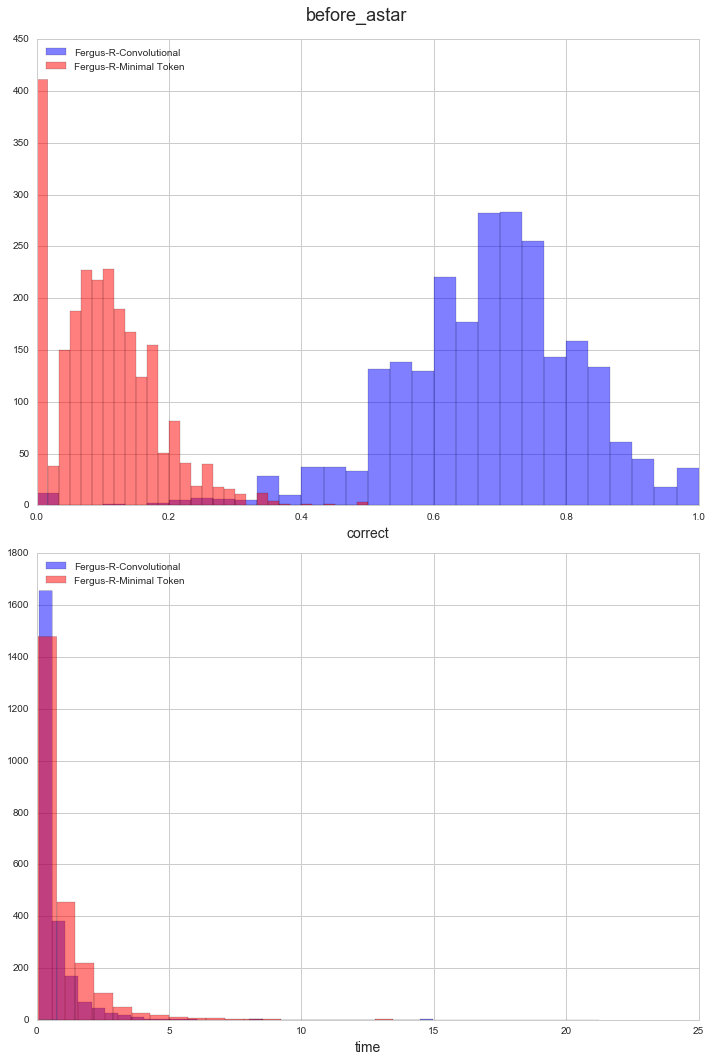

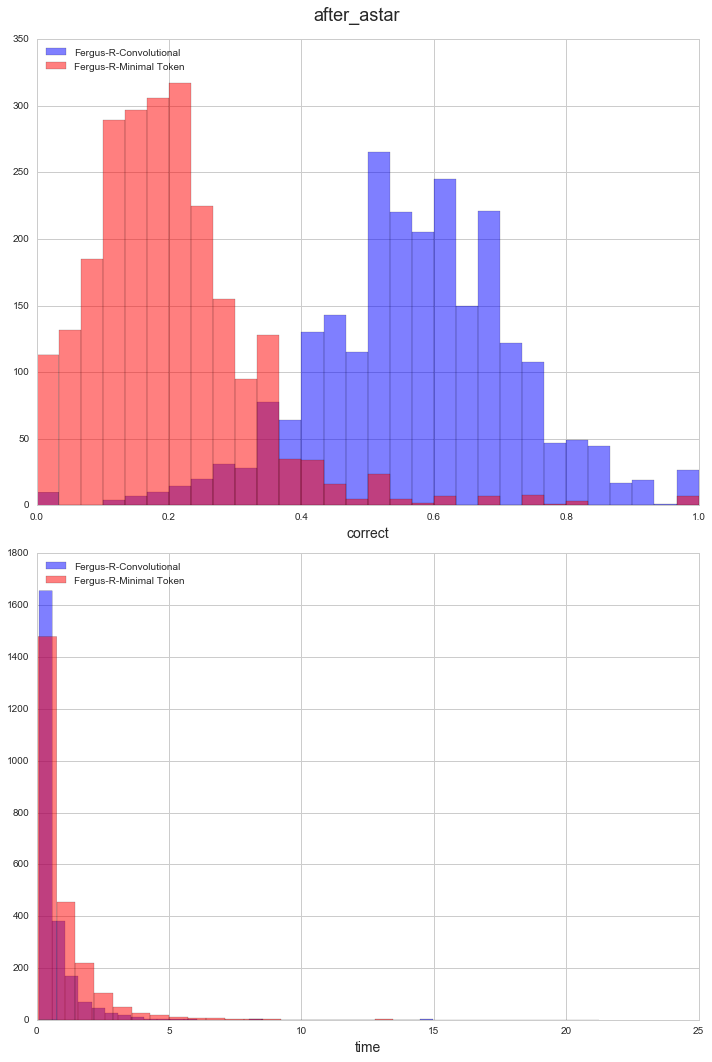

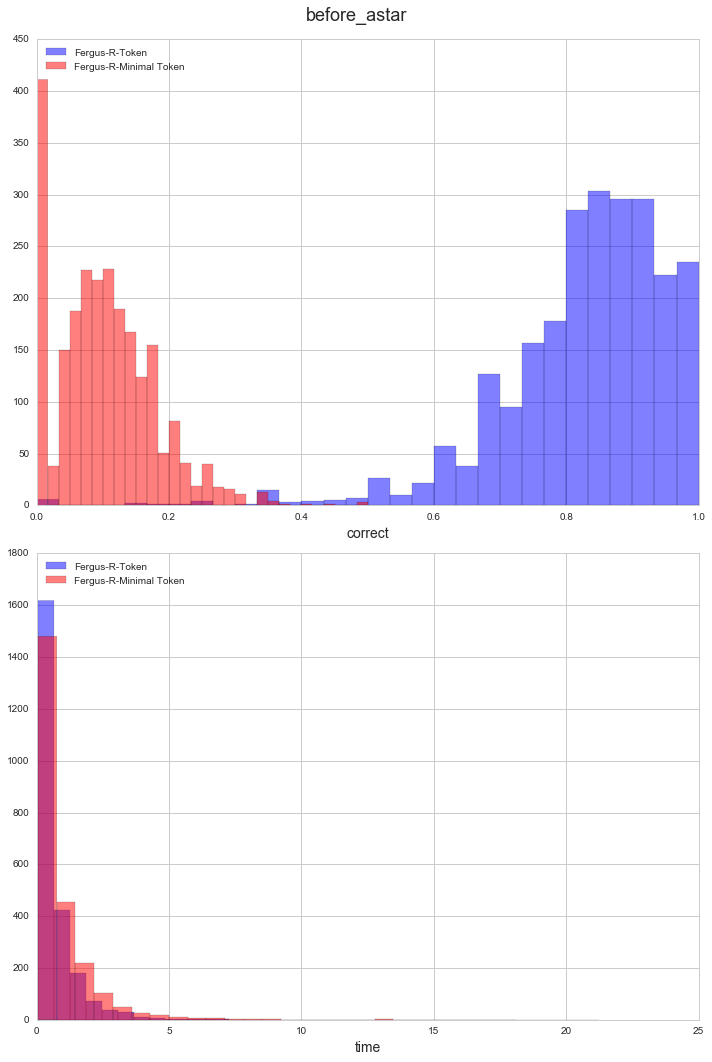

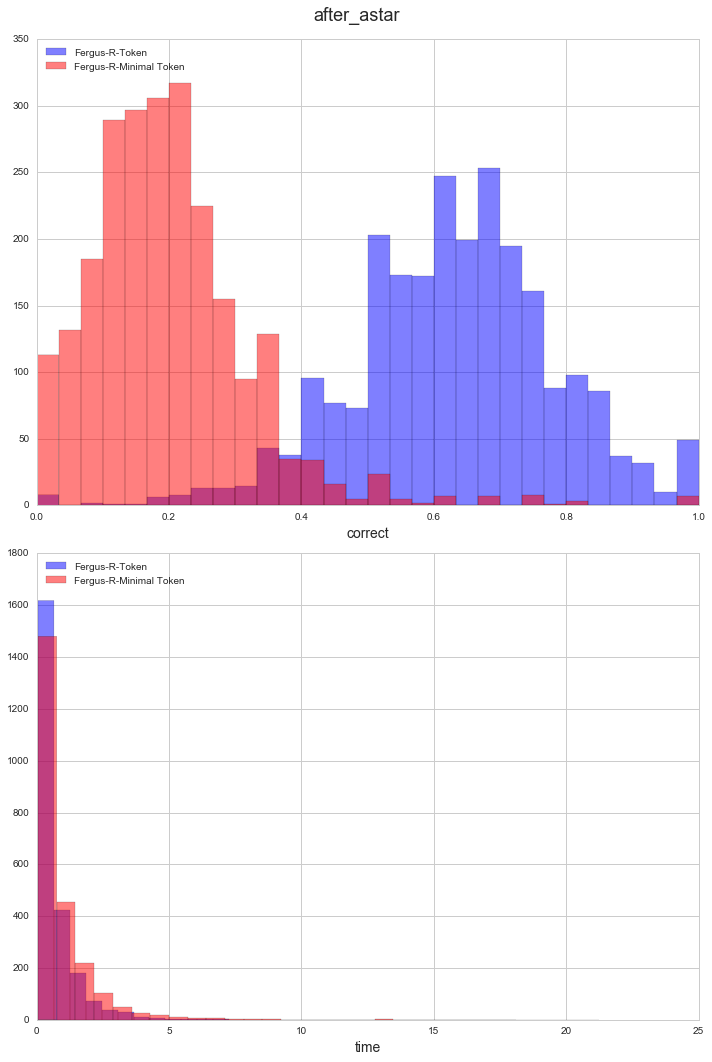

In [20]:
'''
this is comparing the recurrent model with each embedding type
'''
pretty_compare(fr_conv, fr_token, "Fergus-R", "Fergus-R", 
                                  "Convolutional", "Token", "before_astar")


pretty_compare(fr_conv, fr_token, "Fergus-R", "Fergus-R", 
                                  "Convolutional", "Token", "after_astar")

pretty_compare(fr_conv, fr_mintoken, "Fergus-R", "Fergus-R", 
                                  "Convolutional", "Minimal Token", "before_astar")


pretty_compare(fr_conv, fr_mintoken, "Fergus-R", "Fergus-R", 
                                  "Convolutional", "Minimal Token", "after_astar")


pretty_compare(fr_token, fr_mintoken, "Fergus-R", "Fergus-R", 
                                  "Token", "Minimal Token", "before_astar")


pretty_compare(fr_token, fr_mintoken, "Fergus-R", "Fergus-R", 
                                  "Token", "Minimal Token", "after_astar")

Fergus-N-Convolutional vs Fergus-N-Token embeddings before_astar
------correct------ 
	Fergus-N-Convolutional mean    = 0.5811
	Fergus-N-Token mean            = 0.6069
	 pvalue = 1.38815047814e-27
  ---------------   

--------time--------
	Fergus-N-Convolutional median  = 1.9790
	Fergus-N-Token median          = 1.8054
	 pvalue = 1.51107029427e-96
  ---------------   

Fergus-N-Convolutional vs Fergus-N-Token embeddings after_astar
------correct------ 
	Fergus-N-Convolutional mean    = 0.5735
	Fergus-N-Token mean            = 0.5563
	 pvalue = 7.48773714641e-12
  ---------------   

--------time--------
	Fergus-N-Convolutional median  = 1.9790
	Fergus-N-Token median          = 1.8054
	 pvalue = 1.51107029427e-96
  ---------------   

Fergus-N-Convolutional vs Fergus-N-Minimal Token embeddings before_astar
------correct------ 
	Fergus-N-Convolutional mean    = 0.5811
	Fergus-N-Minimal Token mean    = 0.5209
	 pvalue = 1.4282183734e-120
  ---------------   

--------time--------
	Fergus

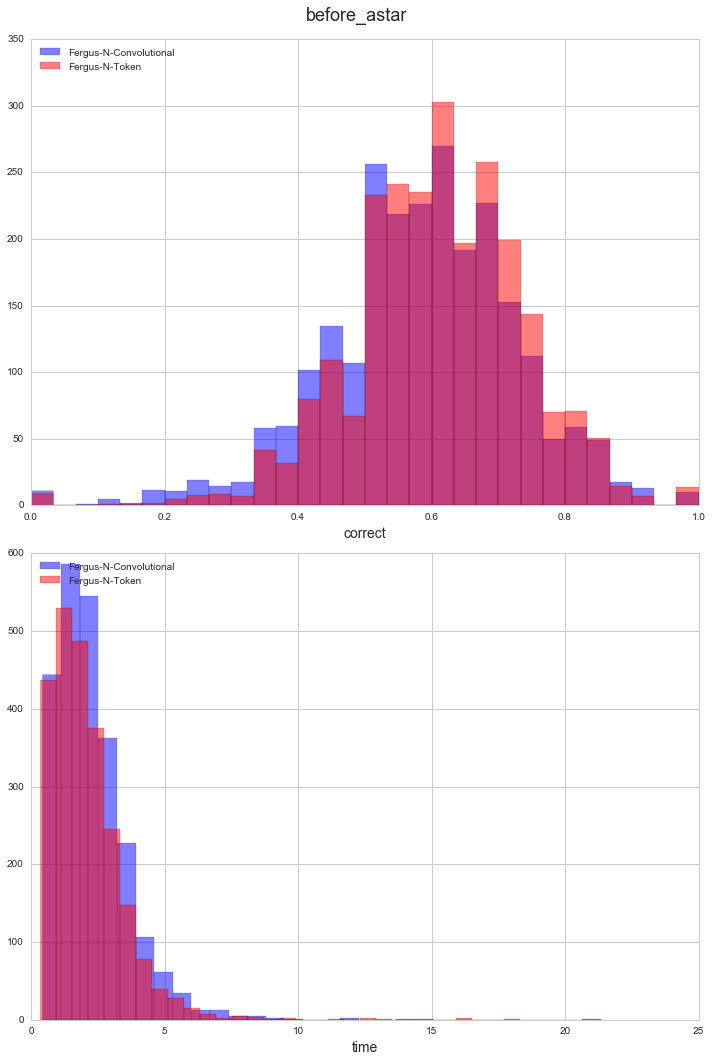

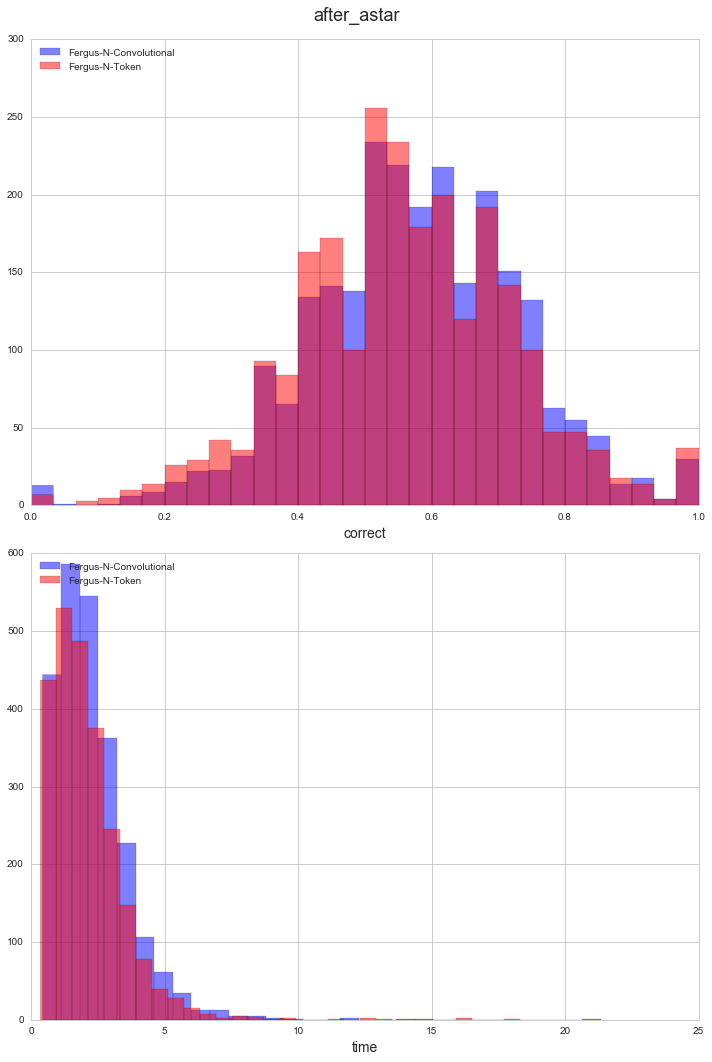

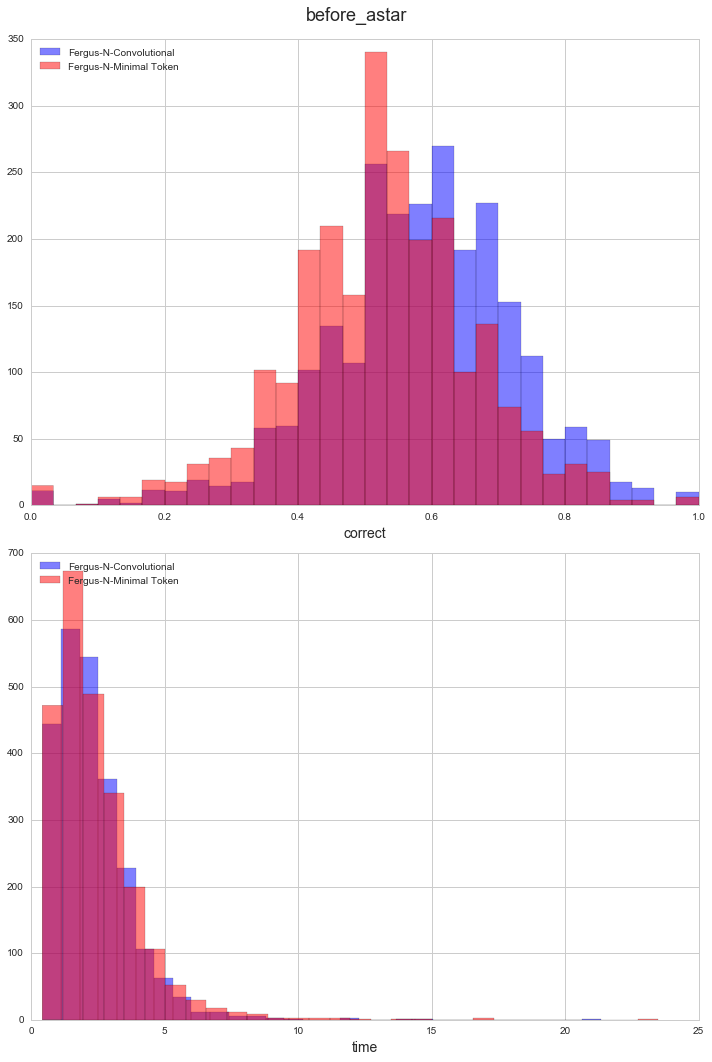

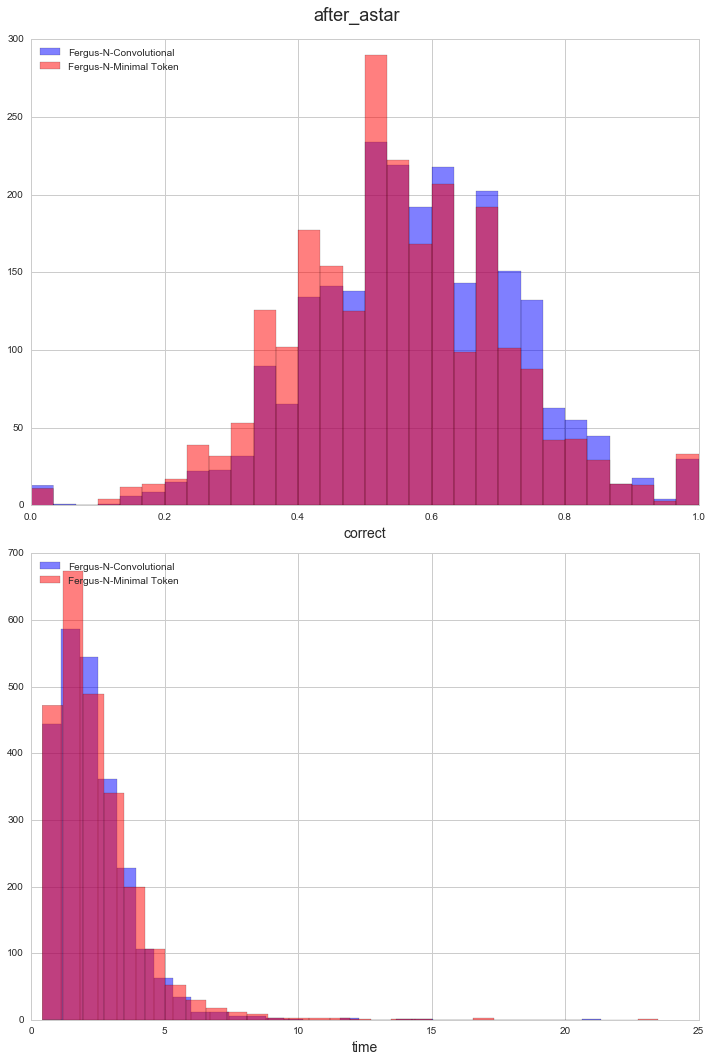

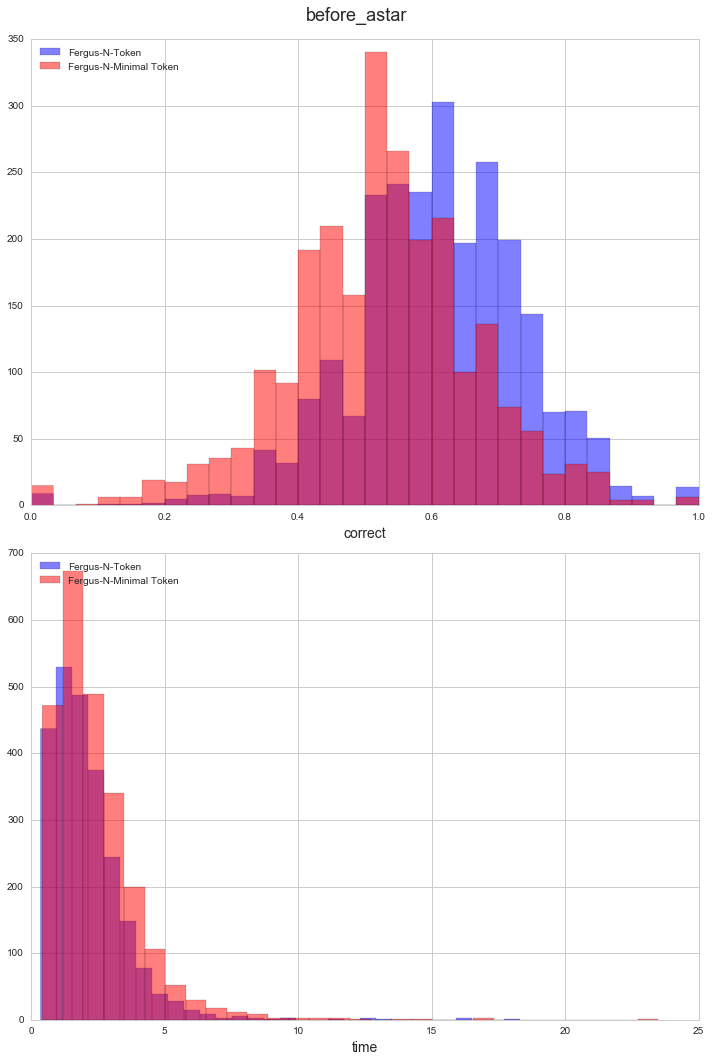

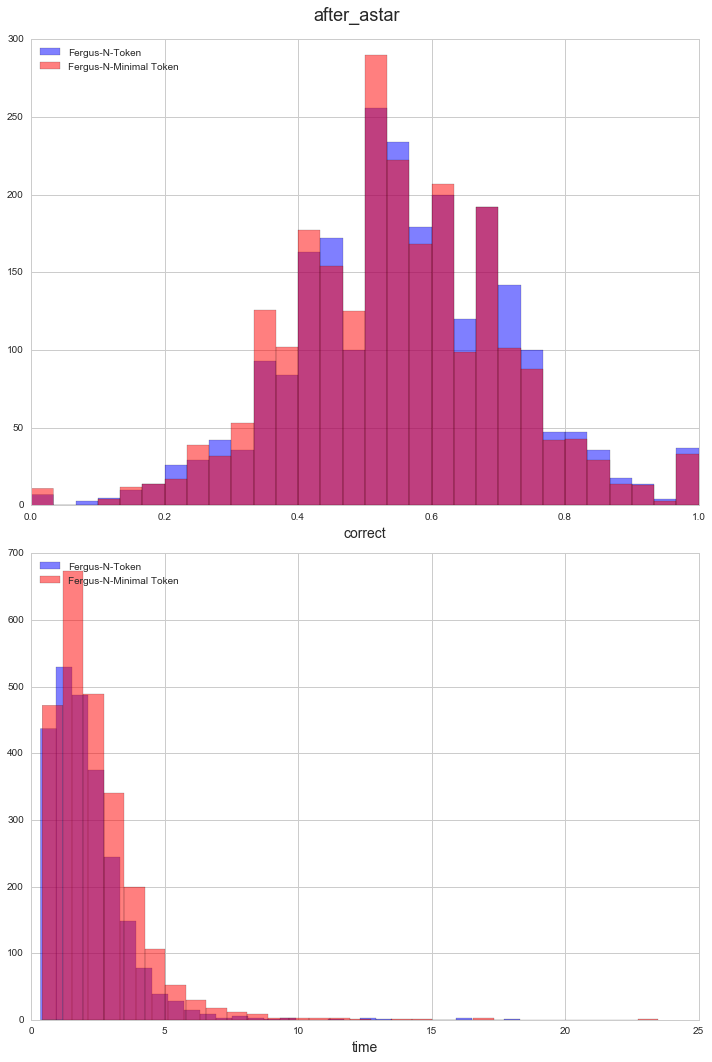

In [21]:
'''
this compares the neuralized model with convolutional or token embeddings
'''
pretty_compare(fn_conv, fn_token, "Fergus-N", "Fergus-N", 
                                  "Convolutional", "Token", "before_astar")
pretty_compare(fn_conv, fn_token, "Fergus-N", "Fergus-N", 
                                  "Convolutional", "Token", "after_astar")


pretty_compare(fn_conv, fn_mintoken, "Fergus-N", "Fergus-N", 
                                  "Convolutional", "Minimal Token", "before_astar")
pretty_compare(fn_conv, fn_mintoken, "Fergus-N", "Fergus-N", 
                                  "Convolutional", "Minimal Token", "after_astar")

pretty_compare(fn_token, fn_mintoken, "Fergus-N", "Fergus-N", 
                                  "Token", "Minimal Token", "before_astar")
pretty_compare(fn_token, fn_mintoken, "Fergus-N", "Fergus-N", 
                                  "Token", "Minimal Token", "after_astar")